In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.maxent_irl_gridworld import run_maxent_irl, draw_path
from pathlib import Path
from matplotlib.colors import ListedColormap

PARSER = argparse.ArgumentParser(description=None)
PARSER.add_argument('-hei', '--height', default=5, type=int, help='height of the gridworld')
PARSER.add_argument('-wid', '--width', default=5, type=int, help='width of the gridworld')
PARSER.add_argument('-g', '--gamma', default=0.8, type=float, help='discount factor')
PARSER.add_argument('-a', '--act_random', default=0.3, type=float, help='probability of acting randomly')
PARSER.add_argument('-t', '--n_trajs', default=100, type=int, help='number of expert trajectories')
PARSER.add_argument('-l', '--l_traj', default=20, type=int, help='length of expert trajectory')
PARSER.add_argument('--rand_start', dest='rand_start', action='store_true', help='when sampling trajectories, randomly pick start positions')
PARSER.add_argument('--no-rand_start', dest='rand_start',action='store_false', help='when sampling trajectories, fix start positions')
PARSER.set_defaults(rand_start=False)
PARSER.add_argument('-lr', '--learning_rate', default=0.01, type=float, help='learning rate')
PARSER.add_argument('-ni', '--n_iters', default=20, type=int, help='number of iterations')
PARSER.add_argument('-act', '--active', action='store_true', help='active learning setting')  # store true
PARSER.add_argument('-al', '--alpha', default=1.0, type=float, help='temperature parameter for value iteration')
PARSER.add_argument('-nq', '--n_query', default=1, type=int, help='number of queries to the expert(n_demonstrations)')
PARSER.add_argument('-rm', '--r_max', default=1, type=int, help='maximum reward value')
PARSER.add_argument('-er', '--error', default=0.01, type=float, help='error threshold for policy evaluation and value iteration')

def parse_args_str(args_str):
    args = PARSER.parse_args(args_str.split())
    return args

In [ ]:
def get_infos(history, active=False, search_idx=None):
    values_gt = history[0]['values_gt']
    idxs = list(history.keys())[1:-1]
    all_values_diff = {'mean': [], 'std': []}
    for i in idxs:
        vd_mean = np.abs(history[i]['values'] - values_gt).mean()
        vd_std = np.abs(history[i]['values'] - values_gt).std()
        all_values_diff['mean'].append(vd_mean)
        all_values_diff['std'].append(vd_std)
    
    if search_idx is None:
        search_idx = idxs[-1]
    else:
        if search_idx not in idxs:
            raise KeyError(f'last_idx should be in available idxs: {idxs}')

    info_dict = {
        'rewards_gt': history[0]['rewards_gt'],
        'values_gt': history[0]['values_gt'],
        'policy_gt': history[0]['policy_gt'],
        'rewards': history_act[search_idx]['rewards'],
        'policy': history_act[search_idx]['policy'],
        'trajs': history_act[0]['trajs'],
        'values': history_act[search_idx]['values'],
    }
    if active:
        info_dict['rewards_new_T'] = history_act[search_idx]['rewards_new_T']
        info_dict['values_new'] = history_act[search_idx]['values_new']
        info_dict['policy_new'] = history_act[search_idx]['policy_new']

    return idxs, all_values_diff, info_dict

def reshaper(args, data):
    return np.reshape(data, (args.height, args.width), order='F')

def draw_maps(args, info_dict, active=False, search_idx=None, file_path=None):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4), dpi=110)
    titles = {
        'rewards_gt': 'Rewards Map (Ground Truth)',
        'values_gt': 'Value Map (Ground Truth)',
        'rewards': 'Rewards Map (Recovered)',
        'values': 'Value Map (Recovered)',
    }
    for (key, title), ax in zip(titles.items(), axes.flatten()):
        ax.set_title(title)
        sns.heatmap(reshaper(args, info_dict[key]), annot=True, fmt='.2f', ax=ax)

    suptitle = 'Active Sampling' if active else 'Random Sampling'
    if search_idx is not None:
        suptitle += f' (N_trajs={search_idx})'
    fig.suptitle(suptitle, fontsize=16)
    plt.tight_layout()
    if file_path is not None:
        fig.savefig((Path(file_path) / f'maps_{"active" if active else "random"}.png'))
    plt.show()

def draw_policy(policy_mat, ax, H, W):
    dirs = {0: '>', 1: '<', 2: 'v', 3: '^', 4: '*'}
    argmax_policy = np.argmax(policy_mat, axis=1)
    pi_dirs = np.array(list(map(dirs.get, argmax_policy)))
    sns.heatmap(reshaper(args, argmax_policy), 
                annot=False, fmt='.2f', linewidths=1.0, cbar=False, cmap=ListedColormap(['white']), ax=ax)
    for i in range(H):
        for j in range(W):
            text = ax.text(
                j+0.5, i+0.5, reshaper(args, pi_dirs).reshape([H, W], order='F')[i, j],
                ha="center", va="center", color="k", fontsize=20)

def draw_acq_maps(args, info_dict, search_idx=None, file_path=None):
    H, W = args.height, args.width
    

    titles = {
        'rewards_gt': 'Rewards Map (Ground Truth)',
        'rewards': 'Rewards Map (Recovered)',
        'policy': 'Policy Map (Recovered)',
        'rewards_new_T': 'Rewards Map (Acquisition)',
        'values_new': 'Value Map (Acquisition)',
        'policy_new': 'Policy Map (Acquisition)'
    }
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    # axes_filtered = [ax for i, ax in enumerate(axes.flatten()) if i != 2]
    # axes[0, 2].axis('off')
    for (key, title), ax in zip(titles.items(), axes.flatten()):
        ax.set_title(title)
        if key in ['policy_new', 'policy']:
            draw_policy(info_dict[key], ax, H, W)
        else:
            sns.heatmap(reshaper(args, info_dict[key]), annot=True, fmt='.2f', ax=ax)
    suptitle = 'Rewards Map Comparison '
    if search_idx is not None:
        suptitle += f' (N_trajs={search_idx}+1)'
    fig.suptitle(suptitle, fontsize=16)
    plt.tight_layout()
    if file_path is not None:
        fig.savefig((Path(file_path) / f'maps_acq_rewards.png'))
    plt.show()

def draw_evd(idxs_act, idxs_rand, vd_act, vd_rand, search_idx=None, file_path=None):
    title = 'Expected value difference'
    if search_idx is not None:
        title += f' (N_trajs={search_idx})'
    if search_idx is None:
        search_idx = len(idxs_act)
    vd_act_mean = np.array(vd_act['mean'])[:search_idx]
    vd_act_std = np.array(vd_act['std'])[:search_idx]
    vd_rand_mean = np.array(vd_rand['mean'])[:search_idx]
    vd_rand_std = np.array(vd_rand['std'])[:search_idx]
    idxs_act = idxs_act[:search_idx]
    idxs_rand = idxs_rand[:search_idx]

    fig, ax = plt.subplots(figsize=(8, 4))

    sns.lineplot(x=idxs_act, y=vd_act_mean, label='active')
    ax.fill_between(idxs_act, vd_act_mean - vd_act_std, vd_act_mean + vd_act_std, alpha=0.3)

    sns.lineplot(x=idxs_rand, y=vd_rand_mean, label='random')
    ax.fill_between(idxs_rand, vd_rand_mean - vd_rand_std, vd_act_mean + vd_rand_std, alpha=0.3)
    
    ax.set_xlabel('Number of acquistions samples')
    ax.set_ylabel('Expected value difference')
    
    ax.set_title(title)
    # ax.set_xticks(idxs_act)
    ax.legend()
    if file_path is not None:
        fig.savefig((Path(file_path) / f'evd.png'))
    plt.show()

Baseline Settings: 

```python
COMMOM_ARGS = """
--height 5
--width 5
--gamma 0.8
--act_random 0.3
--n_trajs 400
--l_traj 15
--learning_rate 0.01
--n_iters 20
--alpha 0.25
--n_query 1
--r_max 1
--error 0.01
"""
```
* Alpha = 1.0 일때 exploitation 하는 경향이 있음
* Alpha = 0.1 일때 gamma 을 0.95 보다 높게 주면 MaxEnt IRL 시 value iteration에서 converge가 안됨..

In [21]:
BASE_ARGS = """
--height 5
--width 5
--gamma 0.8
--act_random 0.3
--n_trajs 400
--l_traj 15
--learning_rate 0.01
--n_iters 20
--alpha 0.25
--n_query 1
--r_max 1
--error 0.01
"""

COMMOM_ARGS = """
--height 5
--width 5
--gamma 0.9
--act_random 0.3
--n_trajs 25
--l_traj 5
--learning_rate 0.05
--n_iters 100
--alpha 1.0
--n_query 1
--r_max 1
--error 0.001
"""

def get_exp_name(BASE_ARGS, COMMOM_ARGS):
    # compare base_args and common_args only get different arguments
    # named with [arg1]_[value1]-[arg2]_[value2] without '--'
    # e.g. height_5-width_5
    base_args = BASE_ARGS.split('\n')
    common_args = COMMOM_ARGS.split('\n')
    exp_name = ''
    for arg in common_args:
        if arg in base_args:
            continue
        else:
            arg_name = arg.split()[0][2:]
            arg_value = arg.split()[1]
            exp_name += f'{arg_name}_{arg_value}-'
    exp_name = exp_name[:-1]
    return exp_name

exp_name = get_exp_name(BASE_ARGS, COMMOM_ARGS)
exp_name

'gamma_0.9-n_trajs_25-l_traj_5-learning_rate_0.05-n_iters_100-alpha_1.0-error_0.001'

In [22]:
init_start_pose = np.random.randint(0, 5, size=(5, 2))

# active learning setting
args = parse_args_str(COMMOM_ARGS + '--active')
print(args)
init_start_pose = np.random.randint(0, args.height, size=(args.n_query, 2)).tolist()

history_act = run_maxent_irl(args, init_start_pose=init_start_pose)

args = parse_args_str(COMMOM_ARGS)
print(args)
history_rand = run_maxent_irl(args, init_start_pose=init_start_pose)

Namespace(height=5, width=5, gamma=0.9, act_random=0.3, n_trajs=25, l_traj=5, rand_start=False, learning_rate=0.05, n_iters=100, active=True, alpha=1.0, n_query=1, r_max=1, error=0.001)
[INFO] Initialize Grid World
[INFO] Getting ground truth values and policy via value teration
[INFO] Initialize trajectories
[INFO] Trajectory length(Include inital starting point) = 6, First trajectories.
2(a=2, r=0.0)->3(a=2, r=0.0)->4(a=0, r=0.0)->4(a=0, r=0.0)->9(a=0, r=0.0)->14(a=0, r=0.0)
[INFO] Start Learning
[INFO - 00001 ] Training MaxEnt IRL
iteration: 0/100
iteration: 5/100
iteration: 10/100
iteration: 15/100
iteration: 20/100
iteration: 25/100
iteration: 30/100
iteration: 35/100
iteration: 40/100
iteration: 45/100
iteration: 50/100
iteration: 55/100
iteration: 60/100
iteration: 65/100
iteration: 70/100
iteration: 75/100
iteration: 80/100
iteration: 85/100
iteration: 90/100
iteration: 95/100
[INFO - 00001 ] Finite Policy Iteration
[INFO - 00001 ] Request a demonstrations
-- Values Map --
[[3.

In [23]:
import pickle
with open(f'./exps/history_act-{exp_name}.pkl', 'wb') as file:
    pickle.dump(history_act, file)
with open(f'./exps/history_rand-{exp_name}.pkl', 'wb') as file:
    pickle.dump(history_rand, file)

---

In [24]:
idxs_act, vd_act, info_act = get_infos(history_act, active=True, search_idx=None)
idxs_rand, vd_rand, info_rand = get_infos(history_rand, active=False, search_idx=None)

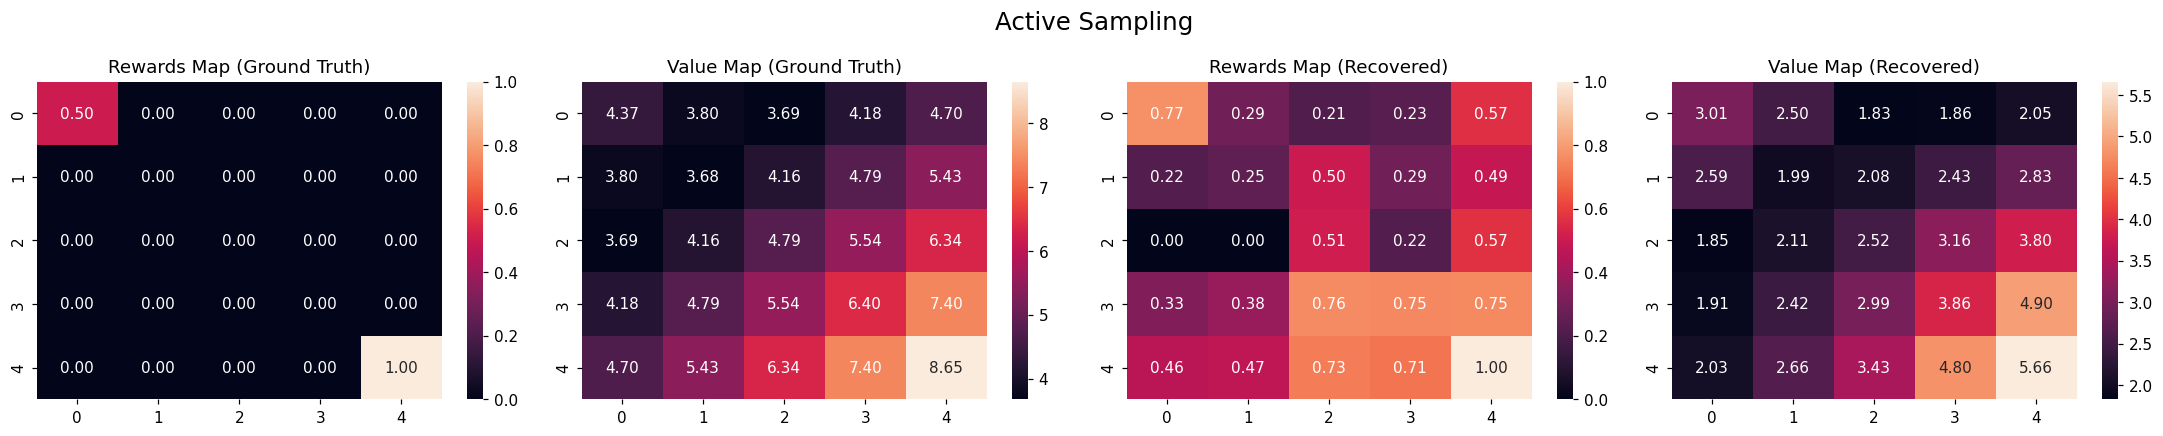

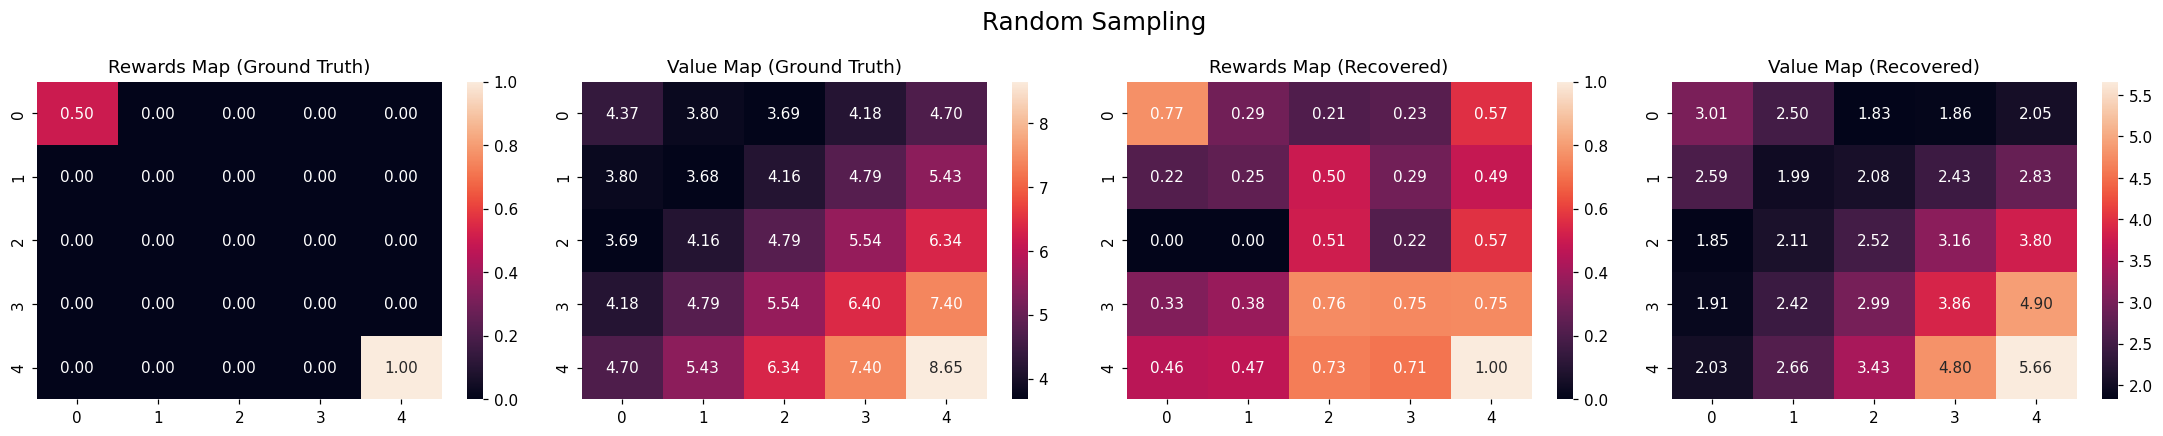

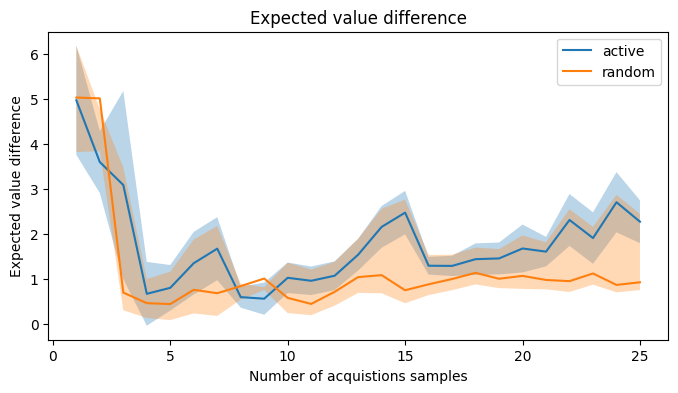

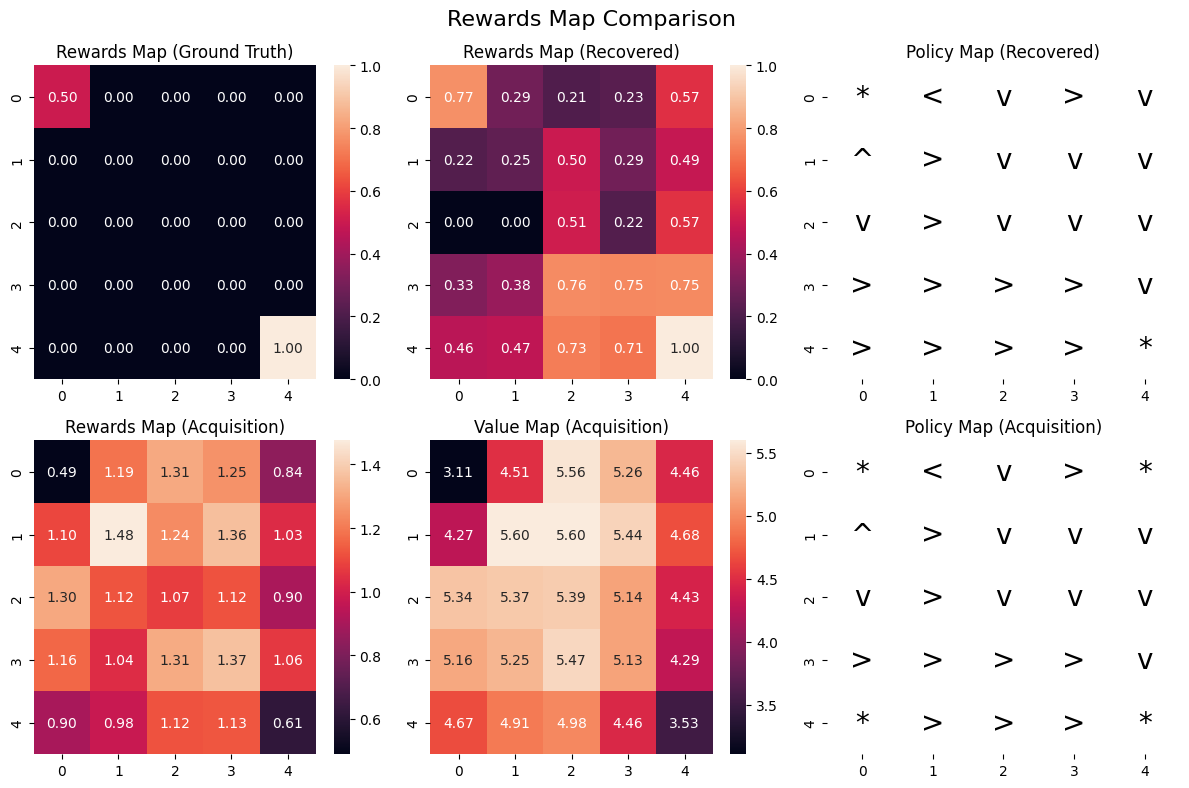

In [25]:
file_path = Path(f'./exp_figs/{exp_name}').resolve()
if not file_path.exists():
    file_path.mkdir(parents=True)
draw_maps(args, info_act, active=True, search_idx=None, file_path=file_path)
draw_maps(args, info_rand, active=False, search_idx=None, file_path=file_path)  # same to info_act
draw_evd(idxs_act, idxs_rand, vd_act, vd_rand, search_idx=None, file_path=file_path)
draw_acq_maps(args, info_act, search_idx=None, file_path=file_path)

In [8]:
search_idx = 20
idxs_act, vd_act, info_act = get_infos(history_act, active=True, search_idx=search_idx)
idxs_rand, vd_rand, info_rand = get_infos(history_rand, active=False, search_idx=search_idx)

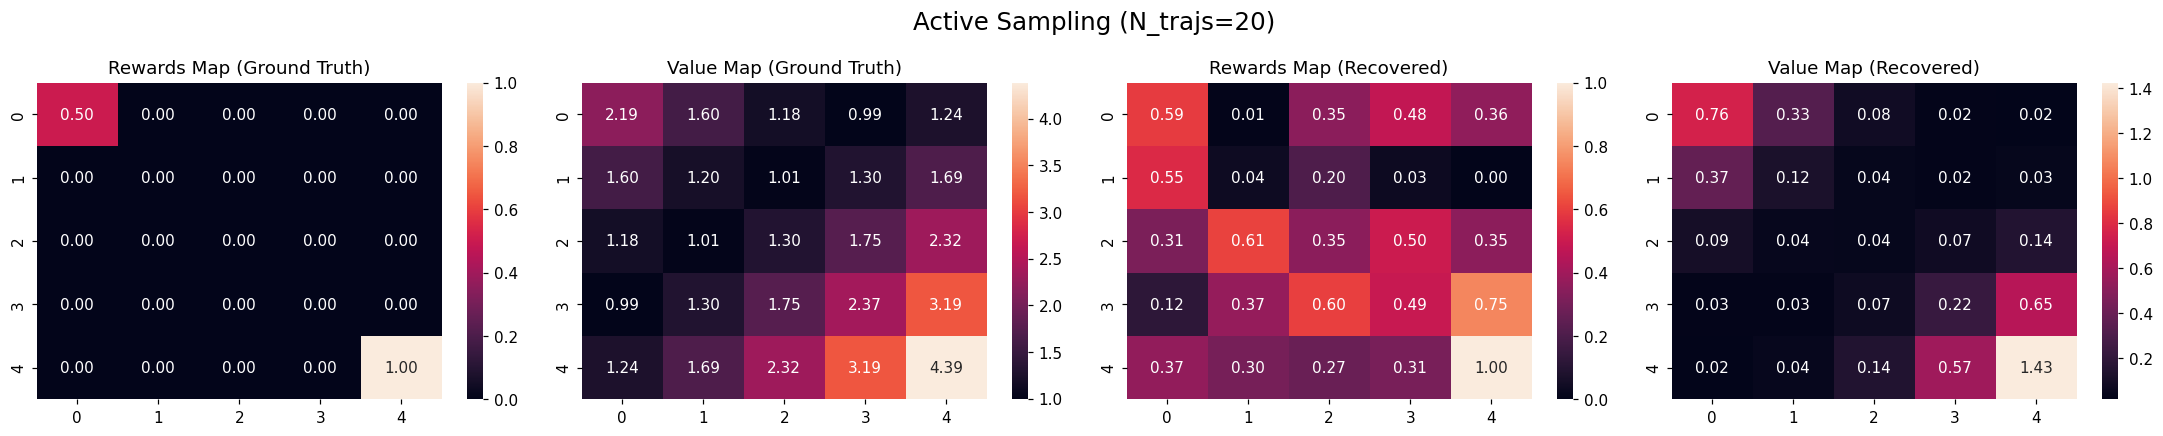

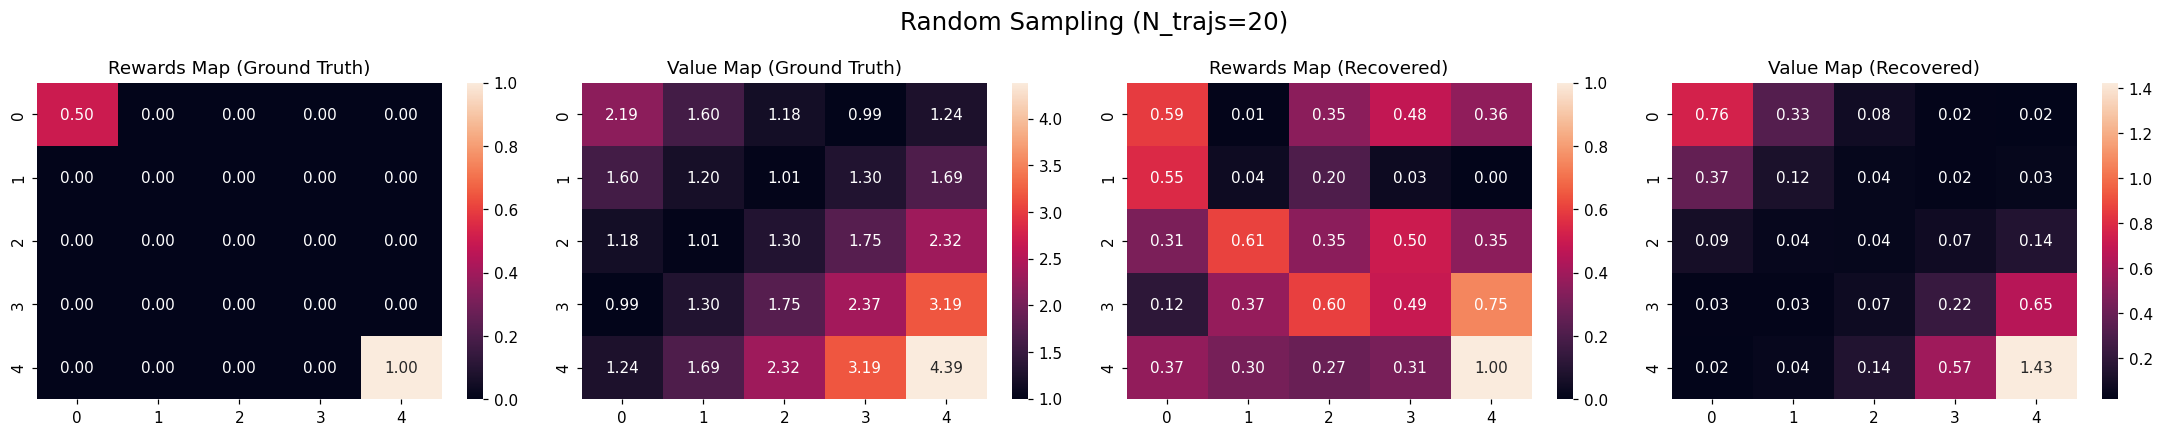

In [9]:
draw_maps(args, info_act, active=True, search_idx=search_idx)
draw_maps(args, info_rand, active=False, search_idx=search_idx)

In [13]:
for e in range(len(history_act[0]['trajs'])):
    print('Episode {}:'.format(e), end=' ')
    print(draw_path(history_act[0]['trajs'][e]))

Episode 0: 20(a=2, r=0.0)->21(a=2, r=0.0)->22(a=2, r=0.0)->23(a=2, r=0.0)->24(a=2, r=1.0)->24(a=0, r=1.0)
Episode 1: 0(a=1, r=0.5)->0(a=1, r=0.5)->0(a=1, r=0.5)->0(a=1, r=0.5)->0(a=1, r=0.5)->1(a=1, r=0.0)
Episode 2: 13(a=0, r=0.0)->18(a=0, r=0.0)->13(a=0, r=0.0)->18(a=0, r=0.0)->23(a=0, r=0.0)->23(a=2, r=0.0)
Episode 3: 9(a=0, r=0.0)->14(a=0, r=0.0)->13(a=0, r=0.0)->8(a=0, r=0.0)->13(a=0, r=0.0)->12(a=0, r=0.0)
Episode 4: 13(a=0, r=0.0)->18(a=0, r=0.0)->23(a=0, r=0.0)->23(a=2, r=0.0)->23(a=2, r=0.0)->24(a=2, r=1.0)
Episode 5: 23(a=2, r=0.0)->24(a=2, r=1.0)->24(a=0, r=1.0)->24(a=0, r=1.0)->24(a=0, r=1.0)->24(a=0, r=1.0)
Episode 6: 6(a=1, r=0.0)->7(a=1, r=0.0)->2(a=0, r=0.0)->7(a=3, r=0.0)->6(a=0, r=0.0)->11(a=1, r=0.0)
Episode 7: 6(a=1, r=0.0)->1(a=1, r=0.0)->1(a=3, r=0.0)->0(a=3, r=0.5)->0(a=1, r=0.5)->5(a=1, r=0.0)
Episode 8: 6(a=1, r=0.0)->1(a=1, r=0.0)->2(a=3, r=0.0)->1(a=3, r=0.0)->0(a=3, r=0.5)->0(a=1, r=0.5)
Episode 9: 11(a=2, r=0.0)->6(a=2, r=0.0)->7(a=1, r=0.0)->7(a=0, r=0.0)-

In [14]:
for e in range(len(history_rand[0]['trajs'])):
    print('Episode {}:'.format(e), end=' ')
    print(draw_path(history_rand[0]['trajs'][e]))

Episode 0: 20(a=2, r=0.0)->20(a=2, r=0.0)->21(a=2, r=0.0)->22(a=2, r=0.0)->23(a=2, r=0.0)->24(a=2, r=1.0)
Episode 1: 19(a=0, r=0.0)->19(a=0, r=0.0)->24(a=0, r=1.0)->24(a=0, r=1.0)->24(a=0, r=1.0)->24(a=0, r=1.0)
Episode 2: 9(a=0, r=0.0)->14(a=0, r=0.0)->14(a=0, r=0.0)->19(a=0, r=0.0)->24(a=0, r=1.0)->24(a=0, r=1.0)
Episode 3: 5(a=1, r=0.0)->0(a=1, r=0.5)->0(a=1, r=0.5)->0(a=1, r=0.5)->0(a=1, r=0.5)->0(a=1, r=0.5)
Episode 4: 13(a=0, r=0.0)->8(a=0, r=0.0)->13(a=0, r=0.0)->8(a=0, r=0.0)->13(a=0, r=0.0)->18(a=0, r=0.0)
Episode 5: 3(a=0, r=0.0)->8(a=0, r=0.0)->13(a=0, r=0.0)->18(a=0, r=0.0)->18(a=0, r=0.0)->23(a=0, r=0.0)
Episode 6: 15(a=2, r=0.0)->16(a=2, r=0.0)->17(a=2, r=0.0)->17(a=2, r=0.0)->18(a=2, r=0.0)->18(a=0, r=0.0)
Episode 7: 6(a=1, r=0.0)->1(a=1, r=0.0)->1(a=3, r=0.0)->0(a=3, r=0.5)->0(a=1, r=0.5)->0(a=1, r=0.5)
Episode 8: 23(a=2, r=0.0)->24(a=2, r=1.0)->24(a=0, r=1.0)->24(a=0, r=1.0)->24(a=0, r=1.0)->24(a=0, r=1.0)
Episode 9: 11(a=2, r=0.0)->12(a=2, r=0.0)->7(a=0, r=0.0)->8(a=0